In [1]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
import statsmodels.api as sm
from liftover import get_lifter
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics, sv_plot

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%reload_ext autoreload
%autoreload 2

# MYCN Validation Cohort

Based on our work in the initial discovery cohort, there seems to be a cluster of SVs around MYCN. I'd like to see if these are also in the validation cohort.

# Determine MYCN structure

In [2]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

In [3]:
# MYCN-201 is the canonical splice variant
gene_gtfs = {}
gene_attrs = {"MYCN": "MYCN-201"}
for g, g_attr in gene_attrs.items():

    # extract all elements of the gene
    gene_gtfs[g] = gtf[(gtf["attribute"].str.contains(g_attr))]

# save memory
del gtf

# Load in SVs and samples

In [4]:
svs = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.3.trio_cohort.analysis_samples.sites.bed.gz",
    sep="\t",
)

dosages = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.3.trio_cohort.analysis_samples.allele_dosages.bed.gz",
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6,10,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,317,318,332,333,351,352,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
metadata = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.3.cohort_metadata.w_control_assignments.tsv.gz",
    sep="\t",
)

trio_samples = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.3.trio_analysis_cohort.samples.list",
    header=None,
)[0].to_list()

# extract out the samples prsent in the dosage matrix
nbl_samples = metadata[(metadata["disease"] == "neuroblastoma") & (metadata['study_phase'] == 'trio')]["entity:sample_id"].to_list()
nbl_samples = sorted(set(trio_samples) & set(nbl_samples))

control_samples = metadata[(metadata["neuroblastoma_control"]) & (metadata['study_phase'] == 'trio')]["entity:sample_id"].to_list()
control_samples = sorted(set(trio_samples) & set(control_samples))

# create a new sex column for modeling, XY = 1
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

len(nbl_samples), len(control_samples)

(284, 2703)

In [6]:
len(nbl_samples) + len(control_samples)

2987

There are some questions later as to whether these results are influences by ancestry. We define a subset of european samples here.

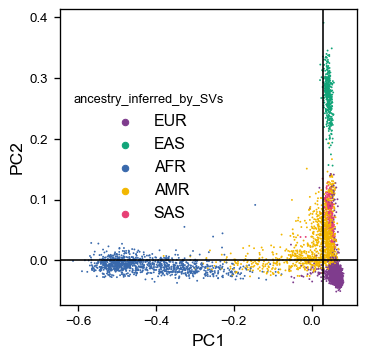

In [11]:
# define some european samples for later
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'ancestry_inferred_by_SVs', data = metadata, s = 2, ec = None)
plt.axvline(x = 0.03, color = 'black')
plt.axhline(y = 0, color = 'black')

We'll use PC1 > 0.03 and PC2 < 0

In [12]:
european_samples = metadata[(metadata['ancestry_inferred_by_SVs'] == 'EUR') &
                            (metadata['PC1'] > 0.03) &
                            (metadata['PC2'] < 0)]['entity:sample_id'].to_list()

european_nbl_samples = list(set(nbl_samples) & set(european_samples))
european_control_samples = list(set(control_samples) & set(european_samples))

len(european_nbl_samples), len(european_control_samples)

(234, 2285)

So the majority of the neuroblastoma samples are from european individuals anyway.

We subset the dosages to just the neuroblastoma samples and their controls:

In [13]:
dosages = dosages[['#chr', 'start', 'end', 'ID'] + nbl_samples + control_samples]

We also remove all SVs that have no counts in genotyped samples. We don't care about these.

In [14]:
# identify the number of samples that have counts for each SV
sv_counts = (dosages.iloc[:, 4:].fillna(0) != 0).sum(axis = 1)

# subset down SVs and dosages
svs = svs[sv_counts > 0]
dosages = dosages[sv_counts > 0]

In [15]:
svs.shape, dosages.shape

((163061, 952), (163061, 2991))

# Specify MYCN location

In [16]:
genes = {
    "MYCN": ["chr2", 15940550, 15947007]
}

gene_locs = pd.DataFrame.from_dict(
    genes, orient="index", columns=["chrom", "start", "end"]
)
gene_locs["gene"] = genes.keys()

In [17]:
gene_locs

,chrom,start,end,gene
MYCN,chr2,15940550,15947007,MYCN


# Isolate the SVs in this region

In [18]:
# get 0.5 Mb on either side of the gene
window_size = 1e6

# expand the gene "locations" to include this window
expanded_gene_locs = gene_locs.copy()
expanded_gene_locs["start"] = (expanded_gene_locs["start"] - window_size / 2).astype(
    int
)
expanded_gene_locs["end"] = (expanded_gene_locs["end"] + window_size / 2).astype(int)

# do the intersection with pybedtools. pybedtools requires either a temp file or
# a string, and we choose the latter.
expanded_gene_bed = pybedtools.BedTool(
    expanded_gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
)
sv_bed = pybedtools.BedTool(
    svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

svs_in_regions = sv_bed.intersect(expanded_gene_bed, wo=True)
svs_in_regions = svs_in_regions.to_dataframe()

# drop unnecessary columns
svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]

In [19]:
svs_in_regions.head()

,chrom,start,end,name,gene
0,chr2,15455387,15455388,PedSV.v2.3_INS_chr2_455,MYCN
1,chr2,15458205,15458288,PedSV.v2.3_DEL_chr2_1653,MYCN
2,chr2,15466903,15470698,PedSV.v2.3_DUP_chr2_697,MYCN
3,chr2,15481480,15481611,PedSV.v2.3_DEL_chr2_1655,MYCN
4,chr2,15546643,16339295,PedSV.v2.3_DUP_chr2_700,MYCN


We "quickly" nab complex SVs as well

In [20]:
# get all complex SVs
complex_svs = svs[(svs["svtype"] == "CPX")][
    [
        "name",
        "#chrom",
        "start",
        "end",
        "svtype",
        "CHR2",
        "CPX_INTERVALS",
        "CPX_TYPE",
        "END",
    ]
].copy()

# split each component SV--represented by CPX_INTERVALS--into their own rows
complex_svs = complex_svs.assign(
    intervals=complex_svs["CPX_INTERVALS"].str.split(",")
).explode("intervals")

# convert this data to a proper bed for intersection
complex_sv_bed = complex_svs[["name", "intervals"]].copy()
complex_sv_bed["chrom"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[0].split("_")[-1]
)
complex_sv_bed["start"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[0]
)
complex_sv_bed["end"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[1]
)

# convert to a bedtool
complex_sv_bed = pybedtools.BedTool(
    complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
        sep="\t", index=False, header=False
    ),
    from_string=True,
)

# do our intersection
complex_svs_in_regions = complex_sv_bed.intersect(expanded_gene_bed, wo=True)

complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

# drop unnecessary columns
if len(complex_svs_in_regions):
    complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
    complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
else:
    complex_svs_in_regions = pd.DataFrame(
        columns=["chrom", "start", "end", "name", "gene"]
    )

In [21]:
complex_svs_in_regions

,chrom,start,end,name,gene
0,chr2,16113793,16114189,PedSV.v2.3_CPX_chr2_41,MYCN


In [22]:
# the number of complex SVs recovered, and the number that were in our original simple overlap
len(set(complex_svs_in_regions["name"])), len(
    set(complex_svs_in_regions["name"]) & set(svs_in_regions["name"])
)

(1, 1)

Again, this process picks up only one new SV--a distributed duplication.

## Subsetting and QC'ing SVs in gene regions

To save memory, we subset the big SV and dosage matrices down to just these samples and SVs.

In [23]:
# keep the gene names
svs_in_regions_names = pd.concat(
    [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
)

# drop duplicates - complex SVs that were picked up twice
svs_in_regions_names = svs_in_regions_names.drop_duplicates(subset = ['name'])

In [24]:
len(svs_in_regions_names)

74

So a decent number of SVs in this dataset fall within this region.


In [25]:
svs[svs['name'].isin(svs_in_regions_names['name'])]['svtype'].value_counts()

DEL           46
DUP           16
INS:ME:ALU     7
INS            3
INS:ME:SVA     1
CPX            1
Name: svtype, dtype: int64

There's some CNVs

We fetch all these SVs from the original dataset now and apply some filters:

In [26]:
# subset
subset_svs = svs.set_index("name").loc[svs_in_regions_names["name"]].reset_index()
subset_svs.insert(0, "gene", svs_in_regions_names["gene"].values)

# convert AF to float. We overwrite AF for CNV to 1 arbitrarily
subset_svs['AF'] = subset_svs['AF'].apply(lambda af: float(af) if af != 'None' else 1)

# how many are PASS?
print(subset_svs["FILTER"].value_counts())

# and how many are rare?
print("\nRare:\n", (subset_svs["AF"] < 0.01).value_counts())

PASS    74
Name: FILTER, dtype: int64

Rare:
 True     57
False    17
Name: AF, dtype: int64


In [27]:
print("\nRare:\n", (subset_svs.query('gene == "MYCN"')["AF"] < 0.01).value_counts())


Rare:
 True     57
False    17
Name: AF, dtype: int64


That's not bad. How many pass the filter, are rare, and are present in the dosage matrix?

In [28]:
# only include SVs that pass the FILTER and are in our dosage matrix
svs_to_keep = subset_svs[
    (
        (subset_svs["FILTER"] == "PASS")
        & (subset_svs["name"].isin(dosages["ID"].to_list()))
    )
].copy()

svs_to_keep["rare"] = svs_to_keep["AF"] < 0.01

svs_to_keep.shape

(74, 954)

Text(0.5, 0, 'AF')

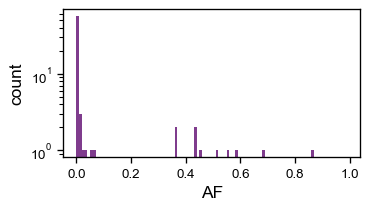

In [29]:
fig, ax = plt.subplots(1, figsize=(4, 2))
plt.hist(svs_to_keep["AF"], bins=np.arange(0, 1, 0.01))
plt.yscale("log")
plt.ylabel("count")
plt.xlabel("AF")

So there are some SVs in this region, and the vast majority are rare (unsurprisingly). We'll analyze them all together, but at some points keep rare separate.

## Extract sample dosages

Here we pull out the allele counts for each SV, so that we can determine case vs. control.

In [30]:
# we begin by subsetting the dosage matrix down to the SVs that we care about. This double counts SVs
# that affect more than one gene.
subset_dosages = dosages[dosages["ID"].isin(svs_to_keep["name"].to_list())].reset_index(
    drop=True
)

# we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
subsetted_gene_dosages = (
    svs_to_keep[["name", "gene", "AF", "rare"]]
    .merge(subset_dosages, right_on="ID", left_on="name")
    .iloc[1:]
)

subsetted_gene_dosages.head(2)

,name,gene,AF,rare,#chr,start,end,ID,PT_00QYKRAX,PT_00Y8C0XA,PT_025YMME2,PT_02AE4RSP,PT_02SNWVRF,PT_06Z51EN5,PT_0CKD259J,PT_0GMP9VVY,PT_0MVMPZKX,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1PA8YT1W,PT_1RGF8S47,PT_1RH3DTPB,PT_1WETGRS9,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2E11C89R,PT_2HW3QVXZ,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_397V1YW0,PT_399GKRRQ,PT_39P91GFA,PT_39TTDEKT,PT_3E2DBRZY,PT_3TE71Z5R,PT_3VNMNFT6,PT_4AK1B8JE,PT_4RVXKBFW,PT_4XJZ1KCB,PT_4Y3P2N1P,PT_534V39HR,PT_56ZM694R,PT_571RCJF0,PT_5BJXQ731,PT_5CPS8GNT,...,TPMCCDG9704,TPMCCDG9710,TPMCCDG9711,TPMCCDG9727,TPMCCDG9729,TPMCCDG9731,TPMCCDG9743,TPMCCDG9751,TPMCCDG9756,TPMCCDG9765,TPMCCDG9771,TPMCCDG9772,TPMCCDG9776,TPMCCDG9777,TPMCCDG9778,TPMCCDG9789,TPMCCDG9791,TPMCCDG9796,TPMCCDG9811,TPMCCDG9813,TPMCCDG9815,TPMCCDG9818,TPMCCDG9821,TPMCCDG9838,TPMCCDG9840,TPMCCDG9841,TPMCCDG9845,TPMCCDG9848,TPMCCDG9849,TPMCCDG9864,TPMCCDG9865,TPMCCDG9886,TPMCCDG9893,TPMCCDG9896,TPMCCDG9902,TPMCCDG9912,TPMCCDG9917,TPMCCDG9919,TPMCCDG9928,TPMCCDG9941,TPMCCDG9945,TPMCCDG9946,TPMCCDG9969,TPMCCDG9973,TPMCCDG9976,TPMCCDG9982,TPMCCDG9992,TPMCCDG9993,TPMCCDG9995,TPMCCDG9999
1,PedSV.v2.3_DEL_chr2_1653,MYCN,0.000074,True,chr2,15458206,15458288,PedSV.v2.3_DEL_chr2_1653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PedSV.v2.3_DUP_chr2_697,MYCN,0.000074,True,chr2,15466904,15470698,PedSV.v2.3_DUP_chr2_697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we devise two metrics for cases and controls--one listing the allele frequency of each SV and another listing the number of samples with an SV in the gene.

We need to convert the dosage (allele count) to allele frequencies.

__Note:__

We also add in the results for the european samples and controls.

In [31]:
case_control_counts = []
case_control_samples_with_svs = []

for sample_group, label in zip(
    [nbl_samples, control_samples, european_nbl_samples, european_control_samples], ["cases", "controls", "euro_cases", "euro_controls"]
):

    # subset to these samples
    sample_dosages = subsetted_gene_dosages[
        ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
    ]

    # first, count the SVs. This function counts the number of samples with each genotype.
    sv_counts = (
        sample_dosages[sample_group]
        .apply(lambda row: row.dropna().value_counts(), axis=1)
        .fillna(0)
        .astype(int)
    )

    # name columns to genotypes
    sv_counts.columns = f"{label}_" + sv_counts.columns.astype(int).astype(str)
    sv_counts["name"] = sample_dosages["name"]

    case_control_counts.append(sv_counts)

    # now count the number of samples with at least one SV around each gene.
    # we groupby gene, then determine whether each sample has an SV in that gene, then
    # count these samples up per gene.
    num_samples_with_svs = sample_dosages.groupby(["gene"]).apply(
        lambda group: (group[sample_group] > 0).any(axis=0).sum()
    )

    num_samples_with_svs.name = label + "_all"
    num_samples_with_svs = num_samples_with_svs / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs)

    # repeat for rare SVs
    num_samples_with_svs_rare = (
        sample_dosages.query("rare == True")
        .groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0).sum())
    )

    num_samples_with_svs_rare.name = label + "_rare"
    num_samples_with_svs_rare = num_samples_with_svs_rare / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs_rare)

# merge
case_control_sv_counts = sample_dosages.iloc[:, :7].reset_index(drop=True)
for df in case_control_counts:
    case_control_sv_counts = case_control_sv_counts.merge(df)

case_control_sv_counts["midpoint"] = np.mean(
    case_control_sv_counts[["start", "end"]], axis=1
)

# and total up the sample counts
case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T

In [32]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,euro_cases_0,euro_cases_1,euro_cases_2,euro_controls_0,euro_controls_1,euro_controls_2,midpoint
0,PedSV.v2.3_DEL_chr2_1653,MYCN,chr2,15458206,15458288,0.000074,True,284,0,0,2702,1,0,234,0,0,2284,1,0,15458247.0
1,PedSV.v2.3_DUP_chr2_697,MYCN,chr2,15466904,15470698,0.000074,True,284,0,0,2702,1,0,234,0,0,2285,0,0,15468801.0


Next we add some columns for allele frequency.

In [33]:
for label in ["cases", "controls", "euro_cases", "euro_controls"]:

    # a quick check to see if there are non-0/1/2 genotypes
    columns = [col for col in case_control_sv_counts.columns if col.startswith(label)]
    assert columns == [f"{label}_{i}" for i in range(3)]

    alt = (case_control_sv_counts[columns] * np.array([0, 1, 2])).sum(axis=1)
    ref = case_control_sv_counts[columns].sum(axis=1) * 2
    case_control_sv_counts[f"AF_{label}"] = alt / ref

In [34]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,euro_cases_0,euro_cases_1,euro_cases_2,euro_controls_0,euro_controls_1,euro_controls_2,midpoint,AF_cases,AF_controls,AF_euro_cases,AF_euro_controls
0,PedSV.v2.3_DEL_chr2_1653,MYCN,chr2,15458206,15458288,0.000074,True,284,0,0,2702,1,0,234,0,0,2284,1,0,15458247.0,0.0,0.000185,0.0,0.000219
1,PedSV.v2.3_DUP_chr2_697,MYCN,chr2,15466904,15470698,0.000074,True,284,0,0,2702,1,0,234,0,0,2285,0,0,15468801.0,0.0,0.000185,0.0,0.000000


In [35]:
case_control_sample_counts

,cases_all,cases_rare,controls_all,controls_rare,euro_cases_all,euro_cases_rare,euro_controls_all,euro_controls_rare
gene,,,,,,,,
MYCN,1.0,0.059859,1.0,0.056234,1.0,0.059829,1.0,0.045514


Any smoking guns in terms of SVs?

In [36]:
freq_diff = case_control_sv_counts["AF_cases"] - (case_control_sv_counts["AF_controls"])

case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].query('rare == True').head(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,euro_cases_0,euro_cases_1,euro_cases_2,euro_controls_0,euro_controls_1,euro_controls_2,midpoint,AF_cases,AF_controls,AF_euro_cases,AF_euro_controls
6,PedSV.v2.3_DEL_chr2_1664,MYCN,chr2,15611607,15611739,0.001341,True,256,4,0,2471,6,0,215,4,0,2118,3,0,15611673.0,0.007692,0.001211,0.009132,0.000707
31,PedSV.v2.3_DEL_chr2_1707,MYCN,chr2,16039508,16039629,0.002648,True,258,4,0,2476,14,0,210,4,0,2083,13,0,16039568.5,0.007634,0.002811,0.009346,0.003101
4,PedSV.v2.3_DEL_chr2_1660,MYCN,chr2,15578442,15579907,0.000074,True,283,1,0,2703,0,0,233,1,0,2285,0,0,15579174.5,0.001761,0.000000,0.002137,0.000000
53,PedSV.v2.3_DUP_chr2_723,MYCN,chr2,16178294,16217346,0.000074,True,283,1,0,2703,0,0,234,0,0,2285,0,0,16197820.0,0.001761,0.000000,0.000000,0.000000


In [37]:
case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].tail(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,euro_cases_0,euro_cases_1,euro_cases_2,euro_controls_0,euro_controls_1,euro_controls_2,midpoint,AF_cases,AF_controls,AF_euro_cases,AF_euro_controls
43,PedSV.v2.3_DEL_chr2_1719,MYCN,chr2,16131505,16133768,0.553735,False,3,263,14,18,2204,448,3,213,14,14,1830,417,16132636.5,0.519643,0.580524,0.523913,0.589120
50,PedSV.v2.3_INS_chr2_470,MYCN,chr2,16148390,16148390,0.517543,False,96,169,19,185,2473,45,85,137,12,170,2077,38,16148390.0,0.364437,0.474103,0.344017,0.471116
47,PedSV.v2.3_DEL_chr2_1723,MYCN,chr2,16146439,16146505,0.430917,False,167,107,10,878,1811,14,141,85,8,791,1484,10,16146472.0,0.223592,0.340178,0.215812,0.329103
56,PedSV.v2.3_DUP_chr2_724,MYCN,chr2,16225124,16226720,0.869601,False,0,120,164,0,361,2342,0,99,135,0,307,1978,16225922.0,0.788732,0.933222,0.788462,0.932823


# Where do these SVs fall relative to MYCN?

We're going to shelve this microdeletion for now, as I need to understand how such a large deletion would be represented. 

This is a little hamfisted, but we'll split by common SVs and then just rare.

In [38]:
expanded_gene_locs = expanded_gene_locs.iloc[[0], :]

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator


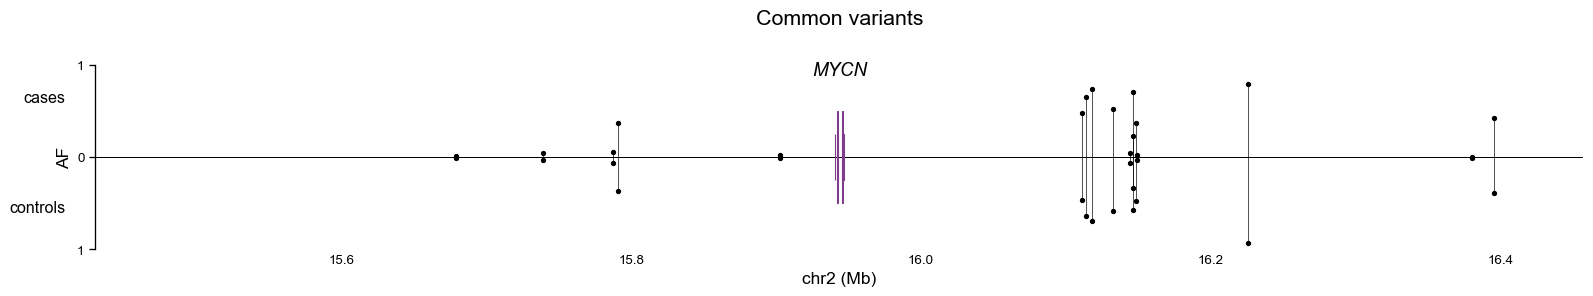

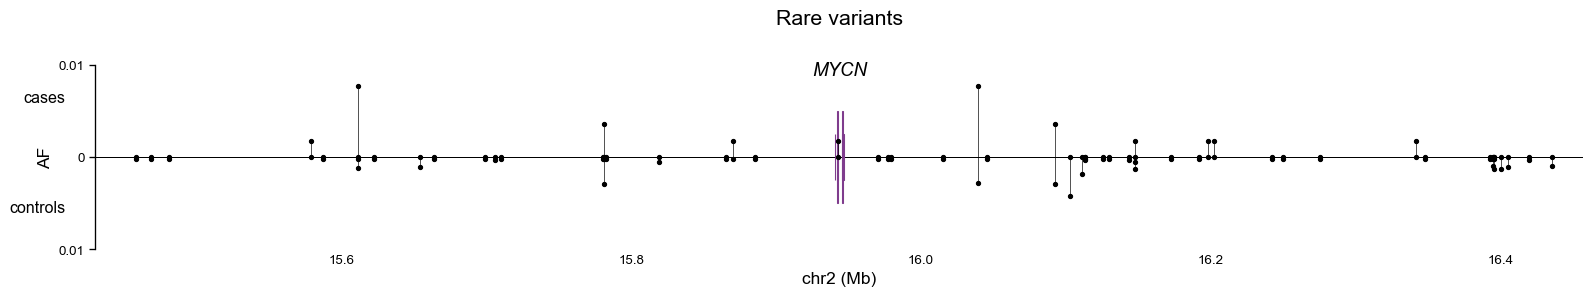

In [39]:
gene = 'MYCN'
for plot in ["common", "rare"]:

    fig, ax = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.5},
    )

    g_gtf = gene_gtfs[g]

    # plot the genetic elements
    feature_colors = {"exon": bold_10[0], "CDS": bold_10[0]}
    window = expanded_gene_locs.loc[g, ["start", "end"]].values
    feature_span = {"exon": 0.25, "CDS": 0.5}

    ax = sv_plot.plot_genomic_elements(
        ax,
        g_gtf,
        window=window,
        feature_span=feature_span,
        feature_colors=feature_colors,
        label=False,
    )
    aesthetics.strip_axis(ax=ax, x="label", y="ignore")

    contig = expanded_gene_locs.loc[g, "chrom"]
    ax.set_title(g, fontstyle="italic", y=0.9)

    # plot the range of interest
    ax.set_xlim(
        expanded_gene_locs.loc[g, ["start", "end"]].values
        + np.array([-10000, 10000])
    )
    ax.spines["bottom"].set_bounds(
        expanded_gene_locs.loc[g, ["start", "end"]].values
    )

    # add labels
    ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
    ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

    # switch to Mb
    ax.set_xticklabels(ax.get_xticks() / 1e6)
    ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    gene_data = plot_svs[plot_svs["gene"] == gene]

    # get the max frequency
    max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

    if plot == "common":
        rounded_max = 1
    if plot == "rare":
        rounded_max = math.ceil(max_freq * 100) / 100

    # its much easier to plot everything at once with plt.stem, but that function sucks
    # we scale the frequency to fill the plot
    case_y = (gene_data["AF_cases"]) / rounded_max
    control_y = (gene_data["AF_controls"]) / rounded_max

    # add the points
    ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
    ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

    # add the lollipop lines
    for loc, case, control in zip(gene_data["midpoint"], case_y, control_y):
        ax.plot(
            [loc, loc],
            [case, -control],
            color="black",
            linewidth=0.5,
            zorder=3,
        )

    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels([rounded_max, 0, rounded_max])
    ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    ax.text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.2,
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    fig.savefig(f"images/mycn-validation-{plot}.png")

Interesting--definitely a ton of possible variants that could be implicated.

# A quick burden test

This is probably going to be significant, but we'll check anyway.

In [40]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_data = metadata[
    metadata["entity:sample_id"].isin(nbl_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"neuroblastoma": 1, "control": 0})

Now we determine the dosages

In [41]:
# for rare, common, and combined variants, we count
for rare in [True, False, 'combined']:

    if rare in [True, False]:
        gene_svs = subsetted_gene_dosages[
            (subsetted_gene_dosages["rare"] == rare)
            & (subsetted_gene_dosages["gene"] == 'MYCN')
        ]
        label = 'rare ' + gene if rare else 'common ' + gene
    elif rare == "combined":
        gene_svs = subsetted_gene_dosages[
            (subsetted_gene_dosages["gene"] == gene)
        ]
        label = 'rare + common ' + gene

    sv_counts = (gene_svs[nbl_samples + control_samples] > 0).sum(axis=0)

    model_data.loc[sv_counts.index, label] = sv_counts

Now we run the model

In [42]:
for svtype in ['rare', 'common', 'rare + common']:
        
    column = svtype + ' ' + 'MYCN'

    # run the model
    endog = model_data["disease"]
    exog = sm.tools.add_constant(model_data[[column] + columns[2:]])
    model = sm.Logit(
        endog,
        exog,
    ).fit(disp=0)

    coeff = model.params[1]
    p = model.pvalues[1]
    print('SV burden', svtype, gene, 'coeff:', coeff, 'p:', p)
    
    # also try a one-hot encoding
    exog[column] = (model_data[column] > 0).astype(int)

    try:
        one_hot_model = sm.Logit(
            endog,
            exog,
        ).fit(disp=0)
    except:
        print('Model failed')
        continue

    coeff = one_hot_model.params[1]
    p = one_hot_model.pvalues[1]
    print("SV one hot", svtype, gene, 'coeff:', coeff, 'p:', p)

SV burden rare MYCN coeff: 0.13172503827185633 p: 0.5819441317347993
SV one hot rare MYCN coeff: 0.13442726555715928 p: 0.62420665760682
SV burden common MYCN coeff: -0.4403981880335193 p: 4.64116298074243e-21
Model failed
SV burden rare + common MYCN coeff: -0.4238197541512983 p: 4.10934168423963e-20
Model failed


# Individual SV analysis

Here we'll go through each SV and run a logit model, incorporating the same variables above, except time we'll use genotype.

We'll also throw in some information here about European samples.

In [43]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + ['PC1', 'PC2', 'PC3']

model_data = metadata[
    metadata["entity:sample_id"].isin(nbl_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"neuroblastoma": 1, "control": 0})

In [44]:
model_data['disease'].value_counts()

0    2703
1     284
Name: disease, dtype: int64

Now we add the genotypes to this model data.

In [45]:
len(set(subsetted_gene_dosages['name']))

73

In [46]:
sv_dosages = subsetted_gene_dosages.set_index("name")[nbl_samples + control_samples]
model_data.loc[sv_dosages.columns, list(sv_dosages.index)] = sv_dosages.T

Next we simply loop through the SVs and run the model.

In [47]:
sv_models = {}
sv_results = []

for sv in sv_dosages.index:

    sv_model_data = model_data[columns[1:] + [sv]]

    # drop samples that could not be genotyped. This inherently introduces bias, so we keep track of the number of samples dropped.
    sv_model_data_nonna = sv_model_data.dropna(subset=[sv]).copy()
    dropped_samples = set(sv_model_data.index) - set(sv_model_data_nonna.index)
    num_cases_dropped = len(set(nbl_samples) & dropped_samples)
    num_controls_dropped = len(set(control_samples) & dropped_samples)

    # we run the model twice - once for all samples, then once for just european samples
    all_samples = list(sv_model_data_nonna.index)
    euro_samples = list(set(all_samples) & set(european_samples))
    
    # run the model
    row = [sv]
    for samples, label in zip([all_samples, euro_samples], ["all", "euro"]):
        sv_model_data_run = sv_model_data_nonna.loc[samples].copy()
        
        try:
            endog = sv_model_data_run["disease"]
            
            # don't consider ancestry if only looking at european samples
            if label == "euro":
                exog = sm.tools.add_constant(sv_model_data_run[[sv, 'sex', 'PC3']])
            else:
                exog = sm.tools.add_constant(sv_model_data_run[[sv] + columns[2:]])

            # suppress some failure warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = sm.Logit(
                    endog=endog,
                    exog=exog,
                ).fit(disp=0, method="bfgs", maxiter=1000)

            # store
            
            row += [model.pvalues[1], model.params[1]]
            sv_models[sv + f'-{label}'] = model

        except:
            row += [np.nan, np.nan]
            
    row += [num_cases_dropped, num_controls_dropped]
    
    sv_results.append(row)

sv_results = pd.DataFrame(
    sv_results,
    columns=["name", "p", "coeff", "euro_p", "euro_coeff", "num_cases_dropped", "num_controls_dropped"],
).set_index("name")

In [48]:
sv_results.head(2)

,p,coeff,euro_p,euro_coeff,num_cases_dropped,num_controls_dropped
name,,,,,,
PedSV.v2.3_DEL_chr2_1653,0.969088,-8.728642,0.999996,-39.826729,0,0
PedSV.v2.3_DUP_chr2_697,0.891435,-3.985198,1.000000,0.000000,0,0


In [49]:
case_control_sv_counts = case_control_sv_counts.merge(sv_results.reset_index()[['name', 'p', 'coeff', 'euro_p', 'euro_coeff']], on = ['name'])

In [50]:
case_control_sv_counts.query('gene == "MYCN" & p < 0.05')

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,euro_cases_0,euro_cases_1,euro_cases_2,euro_controls_0,euro_controls_1,euro_controls_2,midpoint,AF_cases,AF_controls,AF_euro_cases,AF_euro_controls,p,coeff,euro_p,euro_coeff
6,PedSV.v2.3_DEL_chr2_1664,MYCN,chr2,15611607,15611739,0.001341,True,256,4,0,2471,6,0,215,4,0,2118,3,0,15611673.0,0.007692,0.001211,0.009132,0.000707,2.283979e-02,1.563421,1.785177e-02,1.926238
43,PedSV.v2.3_DEL_chr2_1719,MYCN,chr2,16131505,16133768,0.553735,False,3,263,14,18,2204,448,3,213,14,14,1830,417,16132636.5,0.519643,0.580524,0.523913,0.589120,2.022590e-07,-1.164991,2.552409e-06,-1.121798
44,PedSV.v2.3_DEL_chr2_1721,MYCN,chr2,16143101,16149001,0.435004,False,21,80,108,4,2249,367,20,59,92,4,1899,314,16146051.0,0.708134,0.569275,0.710526,0.569914,1.542300e-20,1.409553,8.964533e-18,1.475292
47,PedSV.v2.3_DEL_chr2_1723,MYCN,chr2,16146439,16146505,0.430917,False,167,107,10,878,1811,14,141,85,8,791,1484,10,16146472.0,0.223592,0.340178,0.215812,0.329103,1.758385e-12,-0.897228,6.683148e-11,-0.934407
50,PedSV.v2.3_INS_chr2_470,MYCN,chr2,16148390,16148390,0.517543,False,96,169,19,185,2473,45,85,137,12,170,2077,38,16148390.0,0.364437,0.474103,0.344017,0.471116,4.255586e-22,-1.464671,3.307843e-23,-1.682166
56,PedSV.v2.3_DUP_chr2_724,MYCN,chr2,16225124,16226720,0.869601,False,0,120,164,0,361,2342,0,99,135,0,307,1978,16225922.0,0.788732,0.933222,0.788462,0.932823,3.323962e-30,-1.544345,9.664916e-22,-1.472633
68,PedSV.v2.3_INS_chr2_476,MYCN,chr2,16395357,16395357,0.369259,False,47,236,1,584,2117,1,43,191,0,472,1812,1,16395357.0,0.419014,0.392117,0.408120,0.396937,3.009182e-02,0.369237,3.321467e-01,0.176317


We read in the significant hits from the discovery cohort:

In [51]:
significant_hits = pd.read_csv('data/mycn-discovery-cohort-significant-loci-v2.3.csv')

In [52]:
significant_hits.head(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls,p,coeff
0,PedSV.v2.3_DEL_chr2_1664,MYCN,chr2,15611607,15611739,0.001341,True,426,3,0,1947,1,0,15611673.0,0.003497,0.000257,1.482700e-02,2.885819
1,PedSV.v2.3_DEL_chr2_1698,MYCN,chr2,15941541,15941792,0.039173,False,191,203,1,2031,1,0,15941666.5,0.259494,0.000246,1.136217e-14,7.794697
2,PedSV.v2.3_DUP_chr2_718,MYCN,chr2,16113712,16113862,0.588179,False,22,293,131,120,1826,86,16113787.0,0.622197,0.491634,5.600836e-37,1.816998
3,PedSV.v2.3_DEL_chr2_1719,MYCN,chr2,16131505,16133768,0.553735,False,27,374,31,13,1772,218,16132636.5,0.504630,0.551173,4.843153e-07,-0.963618


In [53]:
# subset our validation cohort down to these SVs
validated_svs = case_control_sv_counts[case_control_sv_counts['name'].isin(significant_hits['name'].to_list())]

In [54]:
export = significant_hits[['name', '#chr', 'start', 'end', 'p', 'coeff', 'AF_cases', 'AF_controls']].merge(validated_svs[['name', '#chr', 'start', 'end', 'p', 'coeff', 'AF_cases', 'AF_controls']], on = ['name', '#chr', 'start', 'end'], suffixes=('_discovery', '_validation'))

In [55]:
export.query('p_discovery < 0.05 & p_validation < 0.05')

,name,#chr,start,end,p_discovery,coeff_discovery,AF_cases_discovery,AF_controls_discovery,p_validation,coeff_validation,AF_cases_validation,AF_controls_validation
0,PedSV.v2.3_DEL_chr2_1664,chr2,15611607,15611739,1.482700e-02,2.885819,0.003497,0.000257,2.283979e-02,1.563421,0.007692,0.001211
2,PedSV.v2.3_DEL_chr2_1719,chr2,16131505,16133768,4.843153e-07,-0.963618,0.504630,0.551173,2.022590e-07,-1.164991,0.519643,0.580524
3,PedSV.v2.3_DEL_chr2_1721,chr2,16143101,16149001,2.316114e-41,7.883164,0.869110,0.003170,1.542300e-20,1.409553,0.708134,0.569275
5,PedSV.v2.3_DEL_chr2_1723,chr2,16146439,16146505,7.947976e-110,-2.609024,0.196868,0.715551,1.758385e-12,-0.897228,0.223592,0.340178
6,PedSV.v2.3_INS_chr2_470,chr2,16148390,16148390,3.693677e-63,-4.288730,0.260181,0.719734,4.255586e-22,-1.464671,0.364437,0.474103
7,PedSV.v2.3_DUP_chr2_724,chr2,16225124,16226720,3.682891e-05,-0.443541,0.784116,0.835630,3.323962e-30,-1.544345,0.788732,0.933222
8,PedSV.v2.3_INS_chr2_476,chr2,16395357,16395357,1.964505e-10,0.809232,0.397982,0.317421,3.009182e-02,0.369237,0.419014,0.392117


In [56]:
significant_hits

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls,p,coeff
0,PedSV.v2.3_DEL_chr2_1664,MYCN,chr2,15611607,15611739,0.001341,True,426,3,0,1947,1,0,15611673.0,0.003497,0.000257,1.482700e-02,2.885819
1,PedSV.v2.3_DEL_chr2_1698,MYCN,chr2,15941541,15941792,0.039173,False,191,203,1,2031,1,0,15941666.5,0.259494,0.000246,1.136217e-14,7.794697
2,PedSV.v2.3_DUP_chr2_718,MYCN,chr2,16113712,16113862,0.588179,False,22,293,131,120,1826,86,16113787.0,0.622197,0.491634,5.600836e-37,1.816998
3,PedSV.v2.3_DEL_chr2_1719,MYCN,chr2,16131505,16133768,0.553735,False,27,374,31,13,1772,218,16132636.5,0.504630,0.551173,4.843153e-07,-0.963618
4,PedSV.v2.3_DEL_chr2_1721,MYCN,chr2,16143101,16149001,0.435004,False,8,84,290,1881,12,0,16146051.0,0.869110,0.003170,2.316114e-41,7.883164
5,PedSV.v2.3_DUP_chr2_721,MYCN,chr2,16143935,16143990,0.063092,False,432,14,1,1651,374,7,16143962.5,0.017897,0.095472,6.729087e-12,-1.791221
6,PedSV.v2.3_DEL_chr2_1723,MYCN,chr2,16146439,16146505,0.430917,False,293,132,22,121,914,997,16146472.0,0.196868,0.715551,7.947976e-110,-2.609024
7,PedSV.v2.3_INS_chr2_470,MYCN,chr2,16148390,16148390,0.517543,False,229,196,17,0,1139,893,16148390.0,0.260181,0.719734,3.693677e-63,-4.288730
8,PedSV.v2.3_DUP_chr2_724,MYCN,chr2,16225124,16226720,0.869601,False,0,193,254,0,668,1364,16225922.0,0.784116,0.835630,3.682891e-05,-0.443541
9,PedSV.v2.3_INS_chr2_476,MYCN,chr2,16395357,16395357,0.369259,False,94,349,3,742,1290,0,16395357.0,0.397982,0.317421,1.964505e-10,0.809232


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


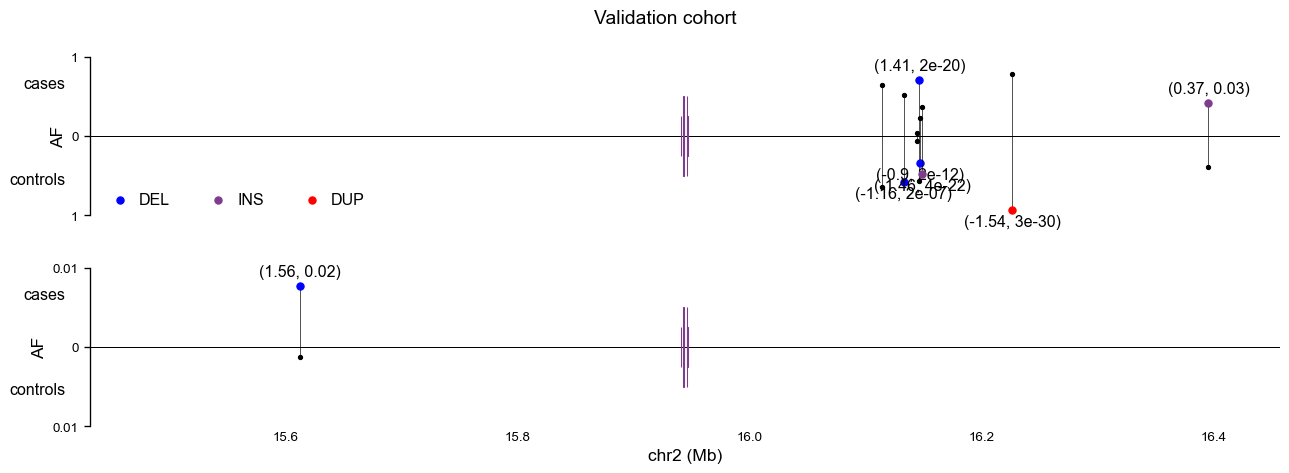

In [57]:
gene = 'MYCN'
sv_colors = {"DEL": "blue", "DUP": "red", "INS": bold_10[0]}
sv_plot_storage = []

fig, axes = plt.subplots(
    2,
    1,
    figsize=(16,  5),
    gridspec_kw={"hspace": 0.33},
)

for plot in ["common", "rare"]:
    
    if plot == 'common':
        ax = axes[0]
    else:
        ax = axes[1]

    g_gtf = gene_gtfs[g]

    # plot the genetic elements
    feature_colors = {"exon": bold_10[0], "CDS": bold_10[0]}
    window = expanded_gene_locs.loc[g, ["start", "end"]].values
    feature_span = {"exon": 0.25, "CDS": 0.5}

    ax = sv_plot.plot_genomic_elements(
        ax,
        g_gtf,
        window=window,
        feature_span=feature_span,
        feature_colors=feature_colors,
        label=False,
    )
    aesthetics.strip_axis(ax=ax, x="label", y="ignore")

    contig = expanded_gene_locs.loc[g, "chrom"]
    # ?ax.set_title(g, fontstyle="italic", y=0.9)

    # plot the range of interest
    ax.set_xlim(
        expanded_gene_locs.loc[g, ["start", "end"]].values
        + np.array([-10000, 10000])
    )
    ax.spines["bottom"].set_bounds(
        expanded_gene_locs.loc[g, ["start", "end"]].values
    )

    # add labels
    ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
    ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

    # switch to Mb
    if plot == 'rare':
        ax.set_xlabel(f"{contig} (Mb)")
        ax.set_xticklabels(ax.get_xticks() / 1e6)
    else:
        aesthetics.strip_axis(ax, y='ignore')

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = validated_svs.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = validated_svs.query("rare == True").copy()

    gene_data = plot_svs[plot_svs["gene"] == gene].reset_index(drop=True)

    # get the max frequency
    max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

    if plot == "common":
        rounded_max = 1
    if plot == "rare":
        rounded_max = math.ceil(max_freq * 100) / 100

    # its much easier to plot everything at once with plt.stem, but that function sucks
    # we scale the frequency to fill the plot
    case_y = (gene_data["AF_cases"]) / rounded_max
    control_y = (gene_data["AF_controls"]) / rounded_max

    # add the points
    ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
    ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

    # add the lollipop lines
    legend_handles = {}
    for j in range(len(gene_data)):
        loc = gene_data["midpoint"][j]
        name = gene_data["name"][j]

        case, control = case_y[j], control_y[j]

        ax.plot(
            [loc, loc],
            [case, -control],
            color="black",
            linewidth=0.5,
            zorder=3,
            )
        
        # look up the p value of the sv, if it exists
        if name in sv_results.index:
            p_val, coeff = sv_results.loc[name, ["p", "coeff"]]

            if p_val < 0.05:

                y = case if coeff > 0 else -control
                text_y = y + 0.18 if coeff > 0 else y - 0.15

                sv_type = svs_to_keep.set_index("name").loc[name, "svtype"]
                color = sv_colors.get(sv_type)

                scatter = ax.scatter(
                    [loc], [y], color=color, s=30, zorder=3, label=sv_type
                )

                if sv_type in ["DUP", "DEL", "INS"]:
                    legend_handles[sv_type] = scatter

                # add text for coeff
                # if coeff < 3:
                ax.text(
                    x=loc,
                    y=text_y,
                    s=f"({round(coeff, 2)}, {p_val:.1})",
                    ha="center",
                    va="center",
                )

    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels([rounded_max, 0, rounded_max])
    ax.set_ylabel("AF")
    
    if plot == 'common':
        ax.legend(
        handles=legend_handles.values(),
        labels=legend_handles.keys(),
        bbox_to_anchor=(0, 0.1),
        ncol=3,
        handletextpad=0.20,
        )
    
    for i in range(1):
        aesthetics.strip_axis(axes[i], y = 'ignore')

    sv_plot_storage.append([fig, axes])
    
fig.suptitle('Validation cohort')
fig.savefig(f"images/validation-MYCN-{plot}-significance.png")